# Direct imputation with the presence of causal SNPs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import scipy

In [3]:
import raiss

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline  

In [6]:
nsnp = 100

## Create a vector of causal effect

Draw causal effect in a normal distribution centered around zero



In [7]:
beta = np.zeros(nsnp) 
beta = np.random.normal(size=nsnp, scale=0.005)

Insert one causal SNPs

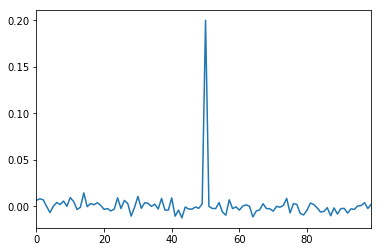

In [8]:
beta[50] = 0.2
pd.Series(beta).plot()

## Simulate trait 

In [9]:
X = pd.read_csv("./data/genotype.csv", sep="\t")

In [10]:
from scipy import stats
from sklearn.preprocessing import StandardScaler

data = [[0, 0], [0, 0], [1, 1], [1, 1]]
scaler = StandardScaler()

X_scl = pd.DataFrame(scaler.fit_transform(X))

/home/genstat/virtual_envs/raiss_review/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/genstat/virtual_envs/raiss_review/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [11]:
sig = 1
noise = np.random.normal(size=X.shape[0], scale=1)
Y = X_scl.dot(beta) + noise

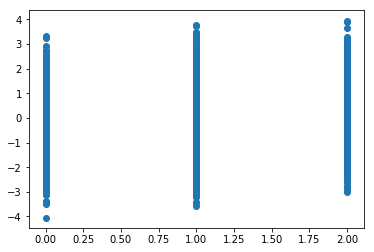

In [12]:
plt.scatter(X.iloc[:,50], Y)

In [13]:
np.var(X_scl.dot(beta))/np.var(Y)

0.03745971122111805

Effect of causal SNP on trait Y


## Derive Zscores 

In [14]:
nind = X.shape[0]
nind**0.5

100.0

In [16]:
sig = 1
noise= np.random.normal(size=X.shape[0], scale=sig)
Y = X_scl.dot(beta) + noise
Zscores = np.zeros(nsnp)
# Compute standardize coefficient

for i in range(100):
    x= X_scl.iloc[:,i]
    b1 = Y.dot(x) / (np.linalg.norm(x,2)**2)
    Zscores[i] = Y.dot(x) / (np.linalg.norm(x,2)*sig)

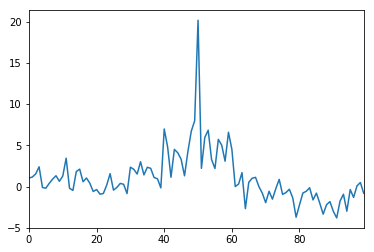

In [17]:
pd.Series(Zscores).plot()


## Estimate a matrix of Linkage desiquilibrium from genotypes


Generate a linkage desiquilibrium by:

* draw correlation in a uniform distribution
* apply a explonetial decay with distance

In [18]:
est_corr = X.corr()

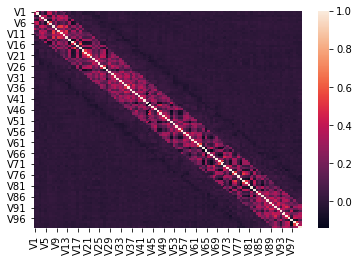

In [19]:
sns.heatmap(est_corr)
LD_cor=est_corr.values

## Determine optimale rcond for imputation

Mask some SNPs in the Zscore vector and test the raiss model for different eigen_ratio.

In [22]:
n_masked = 40
ids_masked = np.random.choice(100, n_masked, replace=False) 
ids_known = np.setdiff1d(np.array(range(100)), ids_masked)

In [23]:
rd_list = np.linspace(0.001,1, 100)
cor_perf = pd.Series(index=rd_list)
L1_perf = pd.Series(index=rd_list)

In [25]:
sig_t_inv = scipy.linalg.pinv(LD_cor[ids_known,:][:,ids_known], rcond=0.1)


In [26]:
# Compute correlation between true and imputed values:
for rd in rd_list:    
    imputed = raiss.stat_models.raiss_model(Zscores[ids_known], pd.DataFrame(LD_cor[ids_known,:][:,ids_known]), LD_cor[ids_masked,:][:,ids_known], rcond=rd)
    imputed['mu']= imputed["mu"]*(1-imputed['var'])**0.5
    cor_perf[rd] =  np.corrcoef(imputed['mu'], Zscores[ids_masked])[0,1]
    L1_perf[rd] = np.linalg.norm(imputed['mu'] - Zscores[ids_masked]) / 100

/home/genstat/virtual_envs/raiss_review/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


optimal eigen_ratio and corresponding correlation

In [27]:
print("optimal eigen ratio {0} maximum correlation {1}".format(np.round(np.argmax(cor_perf), 4), np.round(cor_perf.loc[np.argmax(cor_perf)], 2)))

optimal eigen ratio 0.001 maximum correlation 0.93


/home/genstat/virtual_envs/raiss_review/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


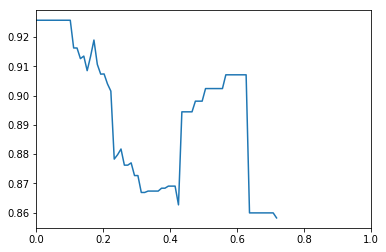

In [28]:
cor_perf.plot()

In [29]:
print("optimal eigen ratio {0} minimum MAE at {1}".format(np.round(np.argmin(L1_perf), 4), np.round(L1_perf.loc[np.argmin(L1_perf)], 2)))

optimal eigen ratio 0.001 minimum MAE at 0.06


/home/genstat/virtual_envs/raiss_review/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


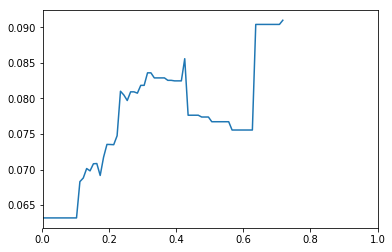

In [30]:
L1_perf.plot()

## Apply imputation for optimal rcond

In [31]:
import matplotlib.pyplot as plt

Text(0.25, 0.65, 'cor : 0.93')

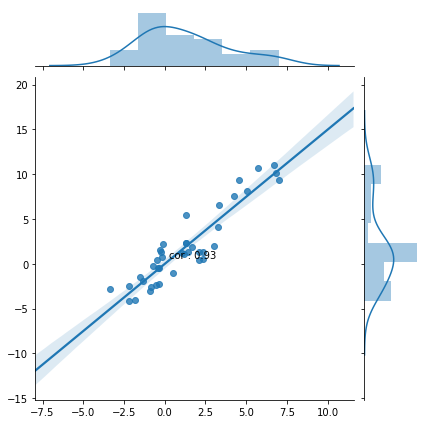

In [32]:
imputed = raiss.stat_models.raiss_model(Zscores[ids_known], pd.DataFrame(LD_cor[ids_known,:][:,ids_known]), LD_cor[ids_masked,:][:,ids_known], rcond=np.argmax(cor_perf))

Zscore_reconstructed = np.copy(Zscores)
Zscore_reconstructed[ids_masked] = imputed['mu'] *((1-imputed['var'])**0.5)

sns.jointplot(Zscores[ids_masked],  imputed['mu'] , kind='reg')
cor = np.corrcoef(Zscores[ids_masked],  imputed['mu']*((1-imputed['var'])**0.5))[0,1]
plt.gca().annotate('cor : {0}'.format(np.round(cor,2)), xy=(0.25, 0.65))

In [33]:
id_large = np.where(np.abs(Zscores[ids_masked]) > 2)[0]

In [34]:
np.linalg.norm(imputed['mu'] - Zscores[ids_masked]) / 100

0.1353486231569787

In [35]:
np.linalg.norm(imputed['mu'][id_large] - Zscores[ids_masked][id_large]) / len(id_large)

0.6688431251457397

Text(0.25, 0.65, 'cor : 0.93')

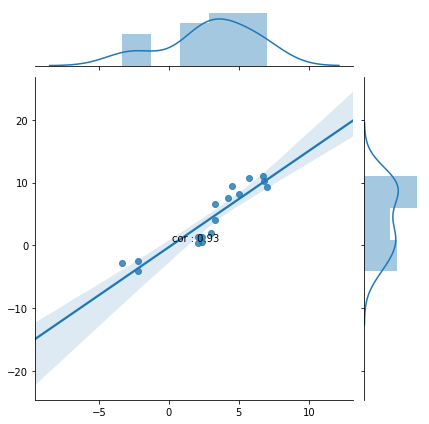

In [36]:

sns.jointplot(Zscores[ids_masked][id_large],  imputed['mu'][id_large] , kind='reg')
cor = np.corrcoef(Zscores[ids_masked][id_large],  imputed['mu'][id_large])[0,1]
plt.gca().annotate('cor : {0}'.format(np.round(cor,2)), xy=(0.25, 0.65))

### Comparison between the imputed and the original signal

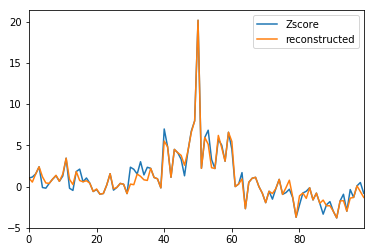

In [37]:
pd.DataFrame({ 'Zscore':Zscores, "reconstructed":Zscore_reconstructed}).plot()

Zoom on only masked and imputed fragment:

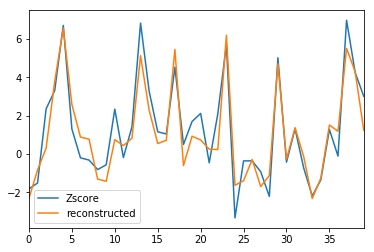

In [38]:
pd.DataFrame({ 'Zscore':Zscores[ids_masked], "reconstructed":Zscore_reconstructed[ids_masked]}).plot()